In [171]:
# The codes for the backtest system contains a large proportion
# transformed from the matlab codes in the homework. 
# Most original comments are remained for the Markowitz part.
# In the Black Litterman part, to avoid redundancy, only the things
# different from Markowitz have comments. 
# Comments following "#//" are codes used to debug only. They can be 
# totally ignored.

##########################################
#### * #######  PREPARAION  ####### * ####
##########################################

import pandas as pd
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cvxpy import *

In [26]:
# Import data and store them in matrices
## daily market price
risk_free_rate = pd.read_csv(r'C:\Users\Yiheng\5370-project2\DGS3MO_daily.csv', index_col=0, header=0)
risk_free_rate = np.array(risk_free_rate)
Price = pd.read_csv(r'C:\Users\Yiheng\5370-project2\new_price_com_mat.csv', index_col=0, header=0)
Price = np.mat(Price)
nc = Price.shape[1] # number of columns

In [27]:
## intraday realized higher moments------for BlackLitterman
Super = pd.read_csv(r'D:\new_super_big_data.csv', index_col=0, header=0)
Returns = np.mat(Super.iloc[:,range(120,120+30,1)])
Variance = np.mat(Super.iloc[:,range(0,0+nc*3,3)])
Skewness = np.mat(Super.iloc[:,range(1,1+nc*3,3)])
Kurtosis = np.mat(Super.iloc[:,range(2,2+nc*3,3)])

In [28]:
import pickle
with open('./weekly_panel_matrices', 'rb') as f:
    pm = pickle.load(f)

In [29]:
with open('./inverted_index', 'rb') as f:
    id = pickle.load(f)

In [30]:
id[5]

Timestamp('2013-03-12 00:00:00')

In [31]:
np.mat(pm[0][id[5]].as_matrix())

matrix([[ 3.07716546e-06,  4.05261876e-07,  6.99565122e-07,
          8.07270400e-07,  2.47181432e-07, -7.19539941e-08,
          1.96549174e-07,  5.06924472e-07,  5.77384287e-07,
          3.26319485e-07,  1.50045591e-07,  6.20869221e-07,
          9.39894530e-08,  1.55375294e-07,  3.43445298e-07,
          4.31187607e-07,  5.35707427e-07, -1.64617544e-07,
          9.56039713e-07,  8.82444442e-07,  9.76923415e-07,
          6.90998375e-07,  4.25267811e-07,  3.03659488e-06,
          4.23527003e-07,  8.86535513e-07, -1.10160608e-07,
         -1.69939780e-07, -1.19417297e-07,  6.73996760e-07],
        [ 4.05261876e-07,  5.74301625e-07,  1.94190859e-07,
          4.28477612e-07,  1.60745545e-07,  9.29180910e-08,
         -6.96043820e-08,  2.20307915e-07,  2.51695563e-07,
          3.27776205e-07,  6.45675377e-08,  1.38863584e-07,
          1.26080997e-07,  4.00459215e-08,  7.21674918e-08,
          6.26899191e-08,  1.74027454e-07, -6.54181983e-08,
          3.74043895e-07,  1.56172834e-

## Basic Statistics 

In [32]:
#Calculate mu and V
##### PRECONDITION: sample_frequency*number_of_samples < trade_date  
def adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay):  
    h = horizon 
    P = Price # the Price matrix, each row refer to a date and each column refers to an asset
    t_d = trade_date # the date you trade, 0,1,2...
    s_f = sample_frequency 
    n_s = number_of_samples
    r_d = rate_of_decay

    s_d = t_d-1-np.arange(n_s+1)*s_f # reverse chronological   
    s_d = s_d[::-1] # chronological    
        # sample dates, a row vector

    S_P = P[s_d,:] # Sample Prices, a matrix
    S_C_R = np.log(S_P[1:,:]/S_P[:-1,:]) #Sample Compound Returns, a matrix
    
    # Now it ’s time to construct the weight
    w = (1.0-float(r_d))**np.arange(1,n_s+1)
    w = w[::-1]
    w = w/sum(w)
    wt = np.transpose([w])  #weights, a non-negative vector that sums to 1
    mean_c_r = S_C_R.T*wt  #mean vector of compound returns
    Cov_C_R = (S_C_R.T*np.diag(w)*S_C_R)-mean_c_r*np.transpose([mean_c_r])
    # covariance matrix of compound returns

    adapted_mean_c_r = mean_c_r*(float(h)/float(s_f))
    # adapting mean vector to reflect length of holding period
    
    Adapted_Cov_C_R = Cov_C_R*(float(h)/float(s_f))
    # adapting covariance matrix to length of holding period

    muu = np.exp(adapted_mean_c_r + 0.5*np.mat(np.diag(Adapted_Cov_C_R)).T)
    mu = muu - 1 # resulting mean vector of ARITHMETIC returns
    
    V = np.multiply((muu*np.transpose([muu.T])),(np.exp(Adapted_Cov_C_R)-1))
    # resulting covariance matrix of ARITHMETIC returns   
    
    return mu,V

In [33]:
# Rebalance the benchmark at the beginning of each holding period to ensure that
# the money are equally invested into all assets including risk free asset at the
# very start of each period.
def rebalance_benchmark_risky(benchmark_x,trans_cost):
    n = np.size(benchmark_x)
    z = Variable(1)
    objective = Maximize(z)
    constraints = [n*z <=sum_entries(benchmark_x)-trans_cost*sum_entries(abs(z-benchmark_x))]
    prob = Problem(objective, constraints)
    result = prob.solve(solver=ECOS)
    prob.solve()
    return z.value

## Benchmark: Markowitz

In [34]:
# Calculate the optimal weight x0 for risk free asset and weight vector x
# for risky assets under markowitz model
def markowitz_risky(mu,V,sigma,xx,trans_cost):
    n = len(mu)
    U = np.linalg.cholesky(V)
    x = Variable(n)
    y = Variable(n)
    total_trans_cost = Variable(1)
    objective = Maximize(mu.T*x)
    constraints = [norm(U*x)<=sigma,
                   sum_entries(x)==1,
                   x==xx+y,
                   #trans_cost*sum_entries(abs(y))==total_trans_cost,
                   x>=0
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    prob.solve()
    return x.value

In [136]:
#######################
### MARKOWITZ.Risky ###
#######################
def runMarkowitz_risky(printTrue,horizon=5,start=10,number_rebalances=10,
                       number_of_samples=5,sample_frequency=1,r_w_f_o_y_e=0.,
                       allowable_risk=1,trans_cost=trans_cost,initial_wealth=initial_wealth,
                       x0=0.,x=(1.0/n)*e):

    rate_of_decay = 0.
    benchmark_wealth = initial_wealth
    wealth = initial_wealth
    portfolio_value = [initial_wealth]
    benchmark_value = [initial_wealth]
    rebalance_dates = start + horizon*np.arange(number_rebalances)
    rf = []

    for i in range(len(rebalance_dates)):
        trade_date = rebalance_dates[i]

        ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
        # It is more natural to rebalance the benchmark portfolio later #

        mu,V = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)
        mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
        rf.append(mu0)

        benchmark_risk = sqrt(quad_form(e,V))/(n)  # there are n+1 financial instruments
                                                     # including the bank
        sigma = allowable_risk*benchmark_risk

        xx0 = 0.
        xx = x
        #// print "mu", mu.T
        x =  markowitz_risky(mu,V,sigma,xx,trans_cost)
        #// print "x0:", x0
        #// print "x:", x.T
        wealth = wealth*(np.sum(x))
            # This is the same thing as updating your wealth by subtracting
            # all transaction costs from the rebalancing.  Indeed, in rebalancing,
            # the proportion of your wealth going to trans costs is 1 - x0 - sum(x).  

        total = x0+sum(x)
        x0 = x0/total
        x = x/total
            # Rescaling x0 and x so that the sum is 1 (i.e., proportions of current wealth)

        ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######

        returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
            # vector of actual returns for risky assets (this is a row vector)

        multiplier = 1+returns*x
        if multiplier<0.5:
            print multiplier
        wealth = multiplier*wealth

        #if(wealth<=0):
        #    break   # stops the program if bankruptcy occurs
                    # Not needed for benchmark portfolio (because it is long only)

        x0 = 0.
        x = np.multiply(x,np.transpose(1+returns))/multiplier
        # these are the proportions of current wealth invested in assets
        # Now its time to rebalance the benchmark portfolio and pay transaction costs

        benchmark_x0 = (1+mu0)/(n)
        benchmark_x = (1+returns)/float(n)

        z = rebalance_benchmark_risky(benchmark_x,trans_cost) 
        benchmark_wealth = benchmark_wealth*(n)*z

        portfolio_value.append(wealth)
        benchmark_value.append(benchmark_wealth)

    markowitz_ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    Markowitz_wealth = wealth
    markowitz_portfolio_value = portfolio_value
    if (printTrue==True):
        #print "your final bank account:", x0 
        #print "your final risky portfolio:", x 
        print "your final wealth:", wealth 
        print "benchmark final wealth:", benchmark_wealth 
        print "your annualized rate of return:", markowitz_ret
        print "benchmark annualized rate of return:", benchmark_annual_return
        plt.figure(1)
        plt.title("Markowitz Accumulated Wealth")
        plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
        plt.plot(range(len(portfolio_value)),portfolio_value,'r',label="Markowitz")
        plt.legend()
        plt.show()
    return markowitz_portfolio_value,markowitz_ret,Markowitz_wealth

## PGP

In [36]:
def Rmax(R):
    n = len(R)
    x = Variable(n)
    objective = Maximize(R.T*x)
    constraints = [sum_entries(x)==1,
                   x>=0
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    return result

In [37]:
def Vmin(V):
    n = len(V)
    U = np.linalg.cholesky(V) 
    x = Variable(n)
    
    objective = Minimize(norm(U*x))
    constraints = [sum_entries(x)==1,
                   x>=0
                   ]
    prob = Problem(objective, constraints)
    result = prob.solve()
    return result

In [38]:
a=[[1,2],[3,4]]
np.mat(np.diag(a))

matrix([[1, 4]])

In [39]:
#REFERENCE: https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.minimize.html
#Rhttps://stackoverflow.com/questions/18767657/how-do-i-use-a-minimization-function-in-scipy-with-constraints
import scipy
from scipy.optimize import minimize
def Scurrent(x,S):
    x2 = np.multiply(np.mat(x),np.mat(x))
    Xm1 = x2.T*np.mat(x)
    Xm2 = np.mat(x).T*x2
    x3 = np.multiply(np.multiply(np.mat(x),np.mat(x)),np.mat(x))
    s = np.mat(S.diagonal())
    #s3 = np.multiply(np.multiply(s,s),s)

    left = float(x3*s.T)
    mid1 = np.sum(np.multiply(Xm1,S))
    mid2 = np.sum(np.multiply(Xm2,S.T))
    res = -5*left+3*mid1+3*mid2
    return res


In [40]:
def Kcurrent(x,K1,K2):
    x2 = np.multiply(np.mat(x),np.mat(x))
    x3 = np.multiply(np.multiply(np.mat(x),np.mat(x)),np.mat(x))
    x4 = np.multiply(np.mat(x2),np.mat(x2))    
    Xm1 = x3.T*np.mat(x)
    Xm2 = np.mat(x).T*x3    
    Xr = x2.T*x2

    k = np.mat(K1.diagonal())
    #k4 = np.multiply(np.multiply(np.multiply(k,k),k),k)

    left = float(x4*k.T)
    mid1 = np.sum(np.multiply(Xm1,K1))
    mid2 = np.sum(np.multiply(Xm2,K1.T))
    right = np.sum(np.multiply(Xr,K2))
    res = -13*left+4*mid1+4*mid2+6*right
    return res


In [41]:
def EntropyCurrent(x):
    return 1-np.sum(x**2)

In [214]:
def PGP(R,V,S,K1,K2,xx,trans_cost,lambda1 = 2.,lambda2 = 2.,lambda3 = 2.,lambda4 = 2.,lambda5=2.0):
#     lambda1 = 2.
#     lambda2 = 2.
#     lambda3 = 2.
#     lambda4 = 2.
    xx = xx
    n = len(V)
    #print xx
    def Smax(S,xx):
        def Smaxob(x):
            Max = -Scurrent(x,S)
            return Max
        def con(x):
            return np.sum(x)-1
        n = len(S)
        bnds = tuple((0,1) for i in range(n))
        cons = {'type':'eq','fun':con}
        result = minimize(Smaxob, xx, bounds=bnds, constraints=cons).fun
        return -result
    #print xx
    #print Smax(S,xx)
    Sm = Smax(S,xx)
    
    
    
    
    def Kmin(K1,K2,xx):
        def Kminob(x):
            Min = Kcurrent(x,K1,K2)
            return Min

        def con(x):
            return np.sum(x)-1
        n = len(K1)
        bnds = tuple((0,1) for i in range(n))
        cons = {'type':'eq','fun':con}
        result = minimize(Kminob, xx, bounds=bnds, constraints=cons).fun
        return result
    #print xx
    #print Kmin(K1,K2,xx)
    Km = Kmin(K1,K2,xx)
    
    def Emax(xx):
        def Emaxob(x):
            Max = -EntropyCurrent(x)
            return Max
        def con(x):
            return np.sum(x)-1
        n = len(S)
        bnds = tuple((0,1) for i in range(n))
        cons = {'type':'eq','fun':con}
        result = minimize(Emaxob, xx, bounds=bnds, constraints=cons).fun
        return -result
    #print xx
    #print Smax(S,xx)
    Em = Emax(xx)
    
    
    
    def PGPob(x):
        Rstar = Rmax(R)
        Vstar = Vmin(V)
        Sstar = Sm
        Kstar = Km
        Estar = Em

        Rcurrent = float(np.dot(x,R))
        Vcurrent = float(np.dot(np.dot(np.mat(x),V),np.mat(x).T))

        d1 = Rstar-Rcurrent
        d2 = Vcurrent-Vstar
        d3 = Sstar-Scurrent(x,S)
        d4 = Kcurrent(x,K1,K2)-Kstar
        d5 = Estar-EntropyCurrent(x)

        Min = ((np.abs(1+d1/Rstar))**lambda1
               +(np.abs(1+d2/Vstar))**lambda2
               +(np.abs(1+d3/Sstar))**lambda3
               +(np.abs(1+d4/Kstar))**lambda4
               + (np.abs(1+d5/Estar))**lambda5)
        return Min

    def con(x):
        return np.sum(x)+np.sum(np.abs(x-xx))*trans_cost-1.
    
    bnds = tuple((0,1) for i in range(n))
    cons = {'type':'eq','fun':con}
    result = minimize(PGPob, xx, bounds=bnds, constraints=cons)
    #print "obj fun= ",result.fun
    ## current mean, var, skewness, kurtosis
    
    
    
    return result.x

In [84]:
#######################
######    PGP    ######
#######################

def runPGP(printTrue,Vall,Sall,K1all,K2all,horizon=5,start=10,number_rebalances=10,
           number_of_samples=5,sample_frequency=1,r_w_f_o_y_e=0,
           allowable_risk=1,trans_cost=trans_cost,initial_wealth=10000,
           x0=0.,x=(1.0/n)*e,lambda1 = 2.,lambda2 = 2.,lambda3 = 2.,lambda4 = 2.,lambda5=2.):

    benchmark_wealth = initial_wealth
    wealth = initial_wealth
    portfolio_value = [initial_wealth]
    benchmark_value = [initial_wealth]
    rebalance_dates = start + horizon*np.arange(number_rebalances)
    rf = []
    rate_of_decay = 0.
    print "lambda1 = ",lambda1," lambda2 = ",lambda2," lambda3 = ",lambda3," lambda4 = ",lambda4," lambda5 = ",lambda5"

    for i in range(len(rebalance_dates)):
        trade_date = rebalance_dates[i]

        ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
        mu = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)[0]
        mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
        rf.append(mu0)
        
        R = mu*0.2
        V = np.mat(Vall[id[trade_date]].as_matrix())
        S = np.mat(Sall[id[trade_date]].as_matrix())
        K1 = np.mat(K1all[id[trade_date]].as_matrix())
        K2 = np.mat(K2all[id[trade_date]].as_matrix())
        
        benchmark_risk = sqrt(quad_form(e,V))/n  # there are n financial instruments
        sigma = allowable_risk*benchmark_risk

        xx0 = x0
        # initial position
        xx = x

        x = PGP(R,V,S,K1,K2,xx,trans_cost,
                lambda1 = lambda1+0.0,lambda2 = lambda2+0.0,lambda3 = lambda3+0.0,lambda4 = lambda4+0.0,lambda5=lambda5+0.0)
        wealth = wealth*(x0+sum(x))
        x0 = 0.
        
        total = x0+sum(x)
        x0 = x0/total
        x = x/total
        ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######

        returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
            # vector of actual returns for risky assets (this is a row vector)

        multiplier = 1+np.sum(np.multiply(returns,x))
        wealth = multiplier*wealth

        if(wealth<=0):
            break   # stops the program if bankruptcy occurs
                    # Not needed for benchmark portfolio (because it is long only)

        x0 = 0.
        x = np.multiply(x,(1.+returns))/multiplier

        #x = np.multiply(x,np.transpose(1.+returns))/multiplier
        # these are the proportions of current wealth invested in assets
        # Now its time to rebalance the benchmark portfolio and pay transaction costs
        
        benchmark_x0 = 0.
        benchmark_x = (1.+returns)/(n)

        z = rebalance_benchmark_risky(benchmark_x,trans_cost) 
        benchmark_wealth = benchmark_wealth*(n)*z
        benchmark_value.append(benchmark_wealth)

        portfolio_value.append(wealth)
#         benchmark_value.append(benchmark_wealth)
        print trade_date

    PGP_ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    benchmark_annual_return = float(benchmark_wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    PGP_wealth = wealth
    PGP_portfolio_value = portfolio_value
    
    markowitz_portfolio_value,markowitz_ret,Markowitz_wealth=runMarkowitz_risky(False,start=start,number_rebalances=number_rebalances)    
    if (printTrue==True):
        #print "your final bank account:", x0 
        #print "your final risky portfolio:", x 
        print "lambda1 = ",lambda1," lambda2 = ",lambda2," lambda3 = ",lambda3," lambda4 = ",lambda4," lambda5 = ",lambda5
        
  
        plt.figure(1)
        plt.title("PGP Accumulated Wealth")
        plt.plot(range(len(benchmark_value)),benchmark_value,'b',label="benchmark")
        plt.plot(range(len(portfolio_value)),PGP_portfolio_value,'g',label="PGP")
        plt.plot(range(len(portfolio_value)),markowitz_portfolio_value,'r',label="Markowitz")
        plt.legend()
        plt.show()
        print "Markowitz_wealth: ", float(Markowitz_wealth),'annualized rate of return:',markowitz_ret
        print "PGP_wealth: ", float(PGP_wealth),'annualized rate of return:',PGP_ret
        print "Benchmark: ", benchmark_wealth,'annualized rate of return:',benchmark_annual_return

    
    RF = np.array([np.array(rf)[i][0] for i in range(len(np.array(rf)))])
    PX_M = np.array(markowitz_portfolio_value)
    PX_P = np.array(PGP_portfolio_value)
    BX = np.array(benchmark_value)
    RP_M = np.array([(PX_M[i+1]/PX_M[i]-1.) for i in range(len(PX_M)-1)])
    RP_P = np.array([(PX_P[i+1]/PX_P[i]-1.) for i in range(len(PX_P)-1)])

    RB = np.array([(BX[i+1]/BX[i]-1.) for i in range(len(BX)-1)])
    Sharpe_Ratio_Benchmark = np.mean(RB-RF)/np.std(RB-RF)
    Sharpe_Ratio_Markowitz = np.mean(RP_M-RF)/np.std(RP_M-RF)
    Sharpe_Ratio_PGP = np.mean(RP_P-RF)/np.std(RP_P-RF)
    if (printTrue==True):       
        print "Sharpe Ratio of Benchmark:\t",Sharpe_Ratio_Benchmark
        print "Sharpe Ratio of Markowitz:\t",Sharpe_Ratio_Markowitz
        print "Sharpe Ratio of PGP:\t",Sharpe_Ratio_PGP
    
    return (Sharpe_Ratio_PGP,Sharpe_Ratio_Benchmark,Sharpe_Ratio_Markowitz,
            PGP_portfolio_value,benchmark_value,markowitz_portfolio_value)
       

In [105]:
def runPGP_select_param(printTrue,Vall,Sall,K1all,K2all,horizon=5,start=10,number_rebalances=8,
           number_of_samples=5,sample_frequency=1,r_w_f_o_y_e=0,
           allowable_risk=1,trans_cost=trans_cost,initial_wealth=10000,
           x0=0.,x=(1.0/n)*e,lambda1 = 2.,lambda2 = 2.,lambda3 = 2.,lambda4 = 2.,lambda5 = 2.):

    benchmark_wealth = initial_wealth
    wealth = initial_wealth
    portfolio_value = [initial_wealth]
    benchmark_value = [initial_wealth]
    rebalance_dates = start + horizon*np.arange(number_rebalances)
    rf = []
    rate_of_decay = 0.

    for i in range(len(rebalance_dates)):
        trade_date = rebalance_dates[i]

        ###### REBALANCE YOUR PORTFOLIO AND PAY TRANSACTION COSTS ######
        mu = adapted_stats(Price,trade_date,horizon,sample_frequency,number_of_samples,rate_of_decay)[0]
        mu0 = (1+0.01*risk_free_rate[trade_date-1])**(float(horizon)/255.0)-1
        rf.append(mu0)
        
        R = mu*0.2
        V = np.mat(Vall[id[trade_date]].as_matrix())
        S = np.mat(Sall[id[trade_date]].as_matrix())
        K1 = np.mat(K1all[id[trade_date]].as_matrix())
        K2 = np.mat(K2all[id[trade_date]].as_matrix())
        
        benchmark_risk = sqrt(quad_form(e,V))/n  # there are n financial instruments
        sigma = allowable_risk*benchmark_risk

        xx0 = x0
        xx = x

        x = PGP(R,V,S,K1,K2,xx,trans_cost,
                lambda1 = lambda1+0.0,lambda2 = lambda2+0.0,lambda3 = lambda3+0.0,lambda4 = lambda4+0.0,lambda5 = lambda5)
        
        if i==0:
            CurM=(x.T*R)[0,0]
            CurV=(np.reshape(x,(1,n))*V*np.reshape(x,(n,1)))[0,0]
            CurS=Scurrent(x,S)
            CurK=Kcurrent(x,K1,K2)
            print "lambda1 = ",lambda1," lambda2 = ",lambda2," lambda3 = ",lambda3," lambda4 = ",lambda4," lambda5 = ",lambda5
            #print "Portfolio:",x
            print "Current Higher Moments:"
            print "Mean: ",CurM
            print "Var : ",CurV
            print "Skew: ",CurS
            print "Kurt: ",CurK
        wealth = wealth*(x0+sum(x))
        x0 = 0.
        
        total = x0+sum(x)
        x0 = x0/total
        x = x/total
        ###### PROCEED TO END OF TIME PERIOD AND ACCOUNT FOR GAINS, LOSSES ######

        returns = (Price[trade_date+horizon-1,:]-Price[trade_date-1,:])/Price[trade_date-1,:]
            # vector of actual returns for risky assets (this is a row vector)

        multiplier = 1+np.sum(np.multiply(returns,x))
        wealth = multiplier*wealth

        if(wealth<=0):
            break   # stops the program if bankruptcy occurs
                    # Not needed for benchmark portfolio (because it is long only)

        x0 = 0.
        x = np.multiply(x,(1.+returns))/multiplier

        #x = np.multiply(x,np.transpose(1.+returns))/multiplier
        # these are the proportions of current wealth invested in assets
        # Now its time to rebalance the benchmark portfolio and pay transaction costs
        

        portfolio_value.append(wealth)
#         benchmark_value.append(benchmark_wealth)
        #print trade_date
    
    PGP_ret=float(wealth/initial_wealth)**(255.0/(horizon*number_rebalances))-1
    PGP_wealth = wealth
    PGP_portfolio_value = portfolio_value

    if (printTrue==True):
        #print "your final bank account:", x0 
        #print "your final risky portfolio:", x 
        
        #print "your final wealth:", wealth 
        #print "your annualized rate of return:", PGP_ret
        print "PGP_wealth: ", float(PGP_wealth),'annualized rate of return:',PGP_ret
        

    if number_rebalances>1:
        RF = np.array([np.array(rf)[i][0] for i in range(len(np.array(rf)))])
        PX_P = np.array(PGP_portfolio_value)
        RP_P = np.array([(PX_P[i+1]/PX_P[i]-1.) for i in range(len(PX_P)-1)])
        Sharpe_Ratio_PGP = np.mean(RP_P-RF)/np.std(RP_P-RF)
        print "Sharpe Ratio of PGP:\t",Sharpe_Ratio_PGP
        print "-"*50
        return [CurM,CurV,CurS,CurK,PGP_ret,Sharpe_Ratio_PGP]
    else:
        print "-"*50
        return [CurM,CurV,CurS,CurK,PGP_ret]
                

## Backtest

In [82]:
##########################################
#### * ########  BACKTEST  ######## * ####
##########################################

n = np.size(Price)/len(Price) # n=number of risky assets
e = np.ones([n,1])

# n=np.size(Vall[id[5]].as_matrix()[0])# n=number of risky assets
# e = np.ones([n,1])
'''
#######################
##### PARAMETERS ######
#######################
'''
# The following choices of parameters can easily be changed.


### horizon: holding period
#horizon = 5 # weekly rebalance
horizon = 20 # monthly rebalance
###

##### PRECONDITION: sample_frequency*number_of_samples < trade_date
# ### weekly rebalance
# start = 100 # the day on which you are first given a portfolio to rebalance
# number_rebalances = 200 # the number of times the portfolio will be rebalanced 
# number_of_samples = 20 # how many samples are to be used 
#                        # in computing return avereages and covariances
# sample_frequency = 1 # 1 = daily, 2 = , etc.
# ###

### monthly rebalance
start = 100 # the day on which you are first given a portfolio to rebalance
number_rebalances = 53 # the number of times the portfolio will be rebalanced 
number_of_samples = 60 # how many samples are to be used 
                       # in computing return avereages and covariances
sample_frequency = 1 # 1 = daily, 2 = , etc.
###


r_w_f_o_y_e = 0.2 # "relative weight for one year earlier" 
                  # -- a value .4 means that for the (exponential) weights 
                  # used in computing return averages and covariances, 
                  # the weight assigned to the time period one year ago
                  # should be .4 times the weight assigned 
                  # to the most recent period.     
allowable_risk = 1
    # This is the level of risk relative to the benchmark portfolio,
    #   where risk is measured as standard deviation of portfolio returns.
    # Choosing this value to equal 1 means exactly the same amount of risk is allowed,
    # whereas choosing 2 means twice as much risk is allowed as the benchmark, and so on.
trans_cost = 0.001  # transaction cost
initial_wealth = 10000 # initial wealth measured in dollars, including money invested in assets
               # (one dollar invested in an asset is considered as one dollar of wealth,
               #  even though in liquidating the asset, transaction costs would be paid)   
x0 = 0.3 # proportion of wealth in bank initially
x = (0.7/n)*e # proportions in risky assets initially

# Signal1 = Variance
# Signal2 = Skewness
# Signal3 = Kurtosis
# At1 = 3
# At2 = 1
# At3 = 3


signal_sample_frequency = 1
number_of_signal_samples = 40 #monthly
rate_of_signal_decay = 0
# Assume the benchmark portfolio is initally equal-weighted, with 1/(n+1) being the 
# proportion of wealth invested in each asset and in the bank.
#### END OF PARAMETERS

In [46]:
Vall = pm[0]#covariance
Sall = pm[1]#coskewness
K1all = pm[2]#cokurtosis_left
K2all = pm[3]#cokurtosis_middle

In [137]:

#np.zeros((n,1))
initial=(1.0/n)*e#np.zeros((n,1))
# initial=(0.+np.mat(range(n)))/np.sum(range(n))
# np.sum(initial)

750
755
760
765
770
775
780
785
790
795
lambda1 =  2.0  lambda2 =  2.0  lambda3 =  2.0  lambda4 =  2.0  lambda5 =  2.0


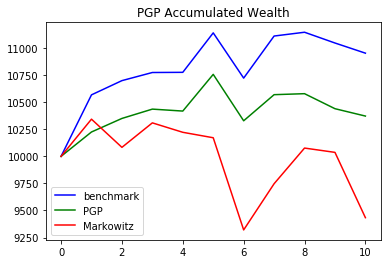

Markowitz_wealth:  9433.38312298 annualized rate of return: -0.257315923652
PGP_wealth:  10372.624174 annualized rate of return: 0.20512494852
Benchmark:  10954.092173363455 annualized rate of return: 0.591620755882
Sharpe Ratio of Benchmark:	0.3678998043239558
Sharpe Ratio of Markowitz:	-0.12594483232054193
Sharpe Ratio of PGP:	0.19089052889716696



In [134]:

FINAL_RESULT2 = runPGP(True,Vall,Sall,K1all,K2all,start=5,number_rebalances=249,x=initial,
                     lambda1 = 2.,lambda2 = 2.,lambda3 = 2.,lambda4 = 2.,lambda5=2.0)
FINAL_RESULT2
print ""

In [135]:
FINAL_RESULT2

(0.19089052889716696,
 0.3678998043239558,
 -0.12594483232054193,
 [10000,
  10225.411094125844,
  10350.66964901664,
  10436.84708720616,
  10418.787284966917,
  10758.09311489456,
  10328.970056029275,
  10570.356670042074,
  10579.515516198142,
  10440.731144502317,
  10372.624174024153],
 [10000,
  10568.681605580057,
  10700.144896270593,
  10775.283824812708,
  10776.856075098824,
  11141.5711563997,
  10723.549825631917,
  11112.348221961665,
  11147.421832626347,
  11047.92999936953,
  10954.092173363455],
 [10000,
  matrix([[10343.9337938]]),
  matrix([[10083.46584343]]),
  matrix([[10309.77759101]]),
  matrix([[10222.55985615]]),
  matrix([[10172.22074862]]),
  matrix([[9320.24967458]]),
  matrix([[9747.14588451]]),
  matrix([[10076.86627864]]),
  matrix([[10037.01786786]]),
  matrix([[9433.38312298]])])

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
lambda1 =  2.0  lambda2 =  2.0  lambda3 =  2.0  lambda4 =  2.0  lambda5 =  2.0
your final wealth: 11550.013738220294
benchmark final wealth: 11641.3556637
your annualized rate of return: 0.44406046122
benchmark annualized rate of return: 0.47336067012


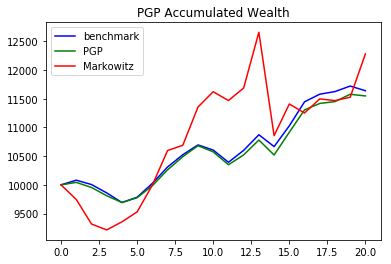

Markowitz_wealth:  12283.7022067 annualized rate of return: 0.689622414565
PGP_wealth:  11550.0137382 annualized rate of return: 0.44406046122
Benchmark:  11641.3556637 annualized rate of return: 0.47336067012
Sharpe Ratio of Benchmark:	0.43548533261626166
Sharpe Ratio of Markowitz:	0.2391271820073955
Sharpe Ratio of PGP:	0.4109908549967855



In [141]:
FINAL_RESULT = runPGP(True,Vall,Sall,K1all,K2all,start=10,number_rebalances=20)
FINAL_RESULT
print ""

In [87]:
## select lambda

param_sel = runPGP_select_param(True,Vall,Sall,K1all,K2all,start=15,number_rebalances=10,
                                lambda1 = 1.,lambda2 = 1.,lambda3 = 1.,lambda4 = 1.,lambda5=1.0)
param_sel
print ""

lambda1 =  1.0  lambda2 =  1.0  lambda3 =  1.0  lambda4 =  1.0  lambda5 =  1.0
Current Higher Moments:
Mean:  0.0026092698833666142
Var :  6.288115811044433e-07
Skew:  0.01567883953466993
Kurt:  0.01393062403719846
15
20
25
30
35
40
45
50
55
60
your final wealth: 10241.903635557795
your annualized rate of return: 0.129643727229
PGP_wealth:  10241.9036356 annualized rate of return: 0.129643727229
--------------------------------------------------
Sharpe Ratio of PGP:	0.14076184389687724



## Param Selection

In [210]:
param0=[[1.0,1.0,1.0,1.0,1.0]]#benchmark
param0=np.mat(param0)
param1=[[1.0,1.0,0.0,0.0,0.0],[1.0,1.0,1.0,1.0,0.0],[1.0,0.0,1.0,1.0,1.0],[3.0,1.0,1.0,1.0,1.0],[3.0,1.0,3.0,1.0,1.0],[1.0,3.0,1.0,1.0,1.0],[1.0,3.0,1.0,3.0,1.0],[1.0,1.0,3.0,1.0,1.0],[1.0,1.0,1.0,3.0,1.0]]
param1=np.mat(param1)


In [103]:
int(param1.shape[0])
param1[i,1]

1.0

In [115]:
range(2)

[0, 1]

In [141]:
param_res0=[]
for i in range(int(param0.shape[0])):
    param_res1.append(runPGP_select_param(True,Vall,Sall,K1all,K2all,start=40,number_rebalances=10,
                                lambda1 =param0[i,0] ,lambda2 = param0[i,1],lambda3 = param0[i,2],lambda4 = param0[i,3],lambda5=param0[i,4]))
print ""

lambda1 =  1.0  lambda2 =  1.0  lambda3 =  1.0  lambda4 =  1.0  lambda5 =  1.0
Current Higher Moments:
Mean:  0.006507207424114996
Var :  3.1444799178069045e-07
Skew:  -0.004580322031810821
Kurt:  0.011354087452064524
PGP_wealth:  11346.8849857 annualized rate of return: 0.90489450597
Sharpe Ratio of PGP:	0.62544718045215
--------------------------------------------------



In [225]:
param_res1=[]
for i in range(int(param1.shape[0])):
    param_res1.append(runPGP_select_param(True,Vall,Sall,K1all,K2all,start=40,number_rebalances=10,
                                lambda1 =param1[i,0] ,lambda2 = param1[i,1],lambda3 = param1[i,2],lambda4 = param1[i,3],lambda5=param1[i,4]))
print ""

lambda1 =  1.0  lambda2 =  1.0  lambda3 =  0.0  lambda4 =  0.0  lambda5 =  0.0
Current Higher Moments:
Mean:  0.08378417109357247
Var :  1.5114060086383764e-05
Skew:  -0.050712937361469784
Kurt:  1.8884320598937379
PGP_wealth:  10419.5181389 annualized rate of return: 0.233169965513
Sharpe Ratio of PGP:	0.10124903444522484
--------------------------------------------------
lambda1 =  1.0  lambda2 =  1.0  lambda3 =  1.0  lambda4 =  1.0  lambda5 =  0.0
Current Higher Moments:
Mean:  0.006135145278561811
Var :  3.129154010987219e-07
Skew:  -0.004807536548279755
Kurt:  0.011274398379196434
PGP_wealth:  11347.2516231 annualized rate of return: 0.905208433923
Sharpe Ratio of PGP:	0.625209987239862
--------------------------------------------------
lambda1 =  1.0  lambda2 =  0.0  lambda3 =  1.0  lambda4 =  1.0  lambda5 =  1.0
Current Higher Moments:
Mean:  0.006125803385120919
Var :  3.127692714245459e-07
Skew:  -0.004866047114576879
Kurt:  0.01127181821525077
PGP_wealth:  11347.4920008 annua

In [217]:
param2=[[1.0,1.0,3.0,0.0,0.0],[2.0,1.0,3.0,0.0,0.0]]
param2=np.mat(param2)
param_res2=[]
for i in range(int(param2.shape[0])):
    param_res2.append(runPGP_select_param(True,Vall,Sall,K1all,K2all,start=40,number_rebalances=10,
                                lambda1 =param2[i,0] ,lambda2 = param2[i,1],lambda3 = param2[i,2],lambda4 = param2[i,3],lambda5=param2[i,4]))
print ""

lambda1 =  1.0  lambda2 =  1.0  lambda3 =  3.0  lambda4 =  0.0  lambda5 =  0.0
Current Higher Moments:
Mean:  -0.002683210739971089
Var :  6.9826332815179655e-06
Skew:  0.5835448125117573
Kurt:  2.2023481006360273
PGP_wealth:  10596.7428968 annualized rate of return: 0.343937978096
Sharpe Ratio of PGP:	0.15910405335564382
--------------------------------------------------
lambda1 =  2.0  lambda2 =  1.0  lambda3 =  3.0  lambda4 =  0.0  lambda5 =  0.0
Current Higher Moments:
Mean:  0.0605411982725598
Var :  6.85984958308489e-06
Skew:  0.41765051410470055
Kurt:  1.2666097324410277
PGP_wealth:  9890.0272175 annualized rate of return: -0.0548359760544
Sharpe Ratio of PGP:	-0.01095413497367553
--------------------------------------------------



In [216]:
param2=[[1.0,1.0,3.0,0.0,0.0],[2.0,1.0,3.0,0.0,0.0],[3.0,1.0,1.0,0.0,0.0],[3.0,1.0,2.0,0.0,0.0],[1.0,1.0,0.0,3.0,0.0],[2.0,1.0,0.0,3.0,0.0],[1.0,3.0,0.0,1.0,0.0],[2.0,3.0,0.0,1.0,0.0]]
param2=np.mat(param2)
param_res2=[]
for i in range(int(param2.shape[0])):
    param_res2.append(runPGP_select_param(True,Vall,Sall,K1all,K2all,start=40,number_rebalances=10,
                                lambda1 =param2[i,0] ,lambda2 = param2[i,1],lambda3 = param2[i,2],lambda4 = param2[i,3],lambda5=param2[i,4]))
print ""

lambda1 =  1.0  lambda2 =  1.0  lambda3 =  1.0  lambda4 =  0.0  lambda5 =  0.0
Current Higher Moments:
Mean:  0.06361067577118111
Var :  7.693148909353372e-06
Skew:  0.40171174564026724
Kurt:  1.360005120958255
PGP_wealth:  11041.1321371 annualized rate of return: 0.657178910857
Sharpe Ratio of PGP:	0.4797536995242455
--------------------------------------------------
lambda1 =  3.0  lambda2 =  1.0  lambda3 =  1.0  lambda4 =  0.0  lambda5 =  0.0
Current Higher Moments:
Mean:  0.07779991578950951
Var :  1.2552573743084514e-05
Skew:  0.15882712287701808
Kurt:  1.8282356971257032
PGP_wealth:  12311.1731522 annualized rate of return: 1.88753423307
Sharpe Ratio of PGP:	0.8427395318360477
--------------------------------------------------
lambda1 =  3.0  lambda2 =  1.0  lambda3 =  1.0  lambda4 =  0.0  lambda5 =  0.0
Current Higher Moments:
Mean:  0.07779991578950951
Var :  1.2552573743084514e-05
Skew:  0.15882712287701808
Kurt:  1.8282356971257032
PGP_wealth:  12311.1731522 annualized rate o

## Strategy Evolution path

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220

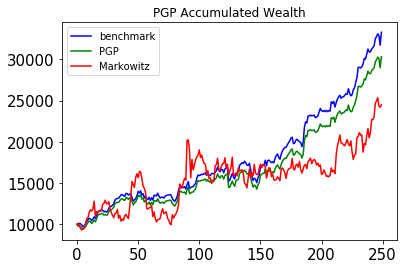

Markowitz_wealth:  24504.9700915 annualized rate of return: 0.201508255325
PGP_wealth:  30332.0315431 annualized rate of return: 0.255170480007
Benchmark:  33297.299955854185 annualized rate of return: 0.279379647132
Sharpe Ratio of Benchmark:	0.23677978252094237
Sharpe Ratio of Markowitz:	0.09266359776091772
Sharpe Ratio of PGP:	0.22054556284099625



In [218]:
FINAL_RESULT2 = runPGP(True,Vall,Sall,K1all,K2all,start=5,number_rebalances=249,x=initial,
                     lambda1 = 1.,lambda2 = 1.,lambda3 = 1.,lambda4 = 1.,lambda5=1.0)
print ""

In [219]:
FINAL_RESULT2

(0.22054556284099625,
 0.23677978252094237,
 0.09266359776091772,
 [10000,
  9736.287571911045,
  9808.118545050054,
  9720.497225250238,
  9579.668927102157,
  9429.435928152892,
  9505.362131507345,
  9729.611293818509,
  10001.835292265496,
  10227.3196966632,
  10398.09043341569,
  10306.674428171107,
  10093.722839346103,
  10272.772976288978,
  10530.645535215694,
  10310.462929116155,
  10674.517873634286,
  11074.511632960412,
  11196.90243267116,
  11233.440779826064,
  11327.161293326999,
  11270.459605994647,
  11116.034077565932,
  11202.35856057068,
  11086.94289344638,
  11152.308383086573,
  11566.019073177153,
  11709.420515953538,
  11760.44425181113,
  11896.478180450593,
  12057.69296224056,
  12488.371198414843,
  12640.092251297112,
  12658.18402840576,
  12658.775185827897,
  12852.391369535571,
  13063.079803700632,
  13091.89408758198,
  12965.145343465436,
  12894.835337857403,
  13241.665172782148,
  13222.532257678879,
  13029.736271421221,
  13187.2163332889

In [146]:
# print FINAL_RESULT
# np.array(FINAL_RESULT[5])

In [222]:
import pickle
with open('final_result2','wb') as fr2:
    pickle.dump(FINAL_RESULT2,fr2)

In [223]:
with open('final_result2','rb') as fr2:
    FR2 = pickle.load(fr2)
FR2

(0.22054556284099625,
 0.23677978252094237,
 0.09266359776091772,
 [10000,
  9736.287571911045,
  9808.118545050054,
  9720.497225250238,
  9579.668927102157,
  9429.435928152892,
  9505.362131507345,
  9729.611293818509,
  10001.835292265496,
  10227.3196966632,
  10398.09043341569,
  10306.674428171107,
  10093.722839346103,
  10272.772976288978,
  10530.645535215694,
  10310.462929116155,
  10674.517873634286,
  11074.511632960412,
  11196.90243267116,
  11233.440779826064,
  11327.161293326999,
  11270.459605994647,
  11116.034077565932,
  11202.35856057068,
  11086.94289344638,
  11152.308383086573,
  11566.019073177153,
  11709.420515953538,
  11760.44425181113,
  11896.478180450593,
  12057.69296224056,
  12488.371198414843,
  12640.092251297112,
  12658.18402840576,
  12658.775185827897,
  12852.391369535571,
  13063.079803700632,
  13091.89408758198,
  12965.145343465436,
  12894.835337857403,
  13241.665172782148,
  13222.532257678879,
  13029.736271421221,
  13187.2163332889

In [149]:
# runMarkowitz(True)
# print ""

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220

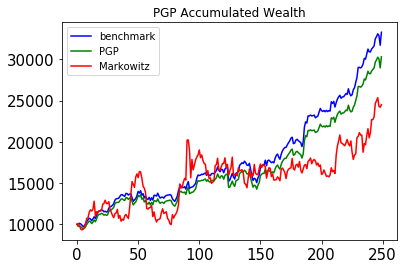

Markowitz_wealth:  24504.9700915 annualized rate of return: 0.201508255325
PGP_wealth:  30318.0468457 annualized rate of return: 0.255051929137
Benchmark:  33297.299955854185 annualized rate of return: 0.279379647132
Sharpe Ratio of Benchmark:	0.23677978252094237
Sharpe Ratio of Markowitz:	0.09266359776091772
Sharpe Ratio of PGP:	0.22042891135670864



(0.22042891135670864,
 0.23677978252094237,
 0.09266359776091772,
 [10000,
  9732.983668257988,
  9804.695143878007,
  9717.07325301012,
  9576.306708762475,
  9426.084931470148,
  9501.856699412047,
  9725.774951104684,
  9997.919759139078,
  10223.322657267921,
  10394.20146486006,
  10302.795194830906,
  10089.91323013273,
  10269.073743614943,
  10526.948871490193,
  10306.90952816505,
  10670.82058423812,
  11070.724428528676,
  11192.960055194813,
  11229.550182972594,
  11323.26226264137,
  11266.534000099886,
  11112.127980078176,
  11198.45847610981,
  11083.112356087131,
  11148.360193011806,
  11561.90457511265,
  11705.257356296146,
  11756.331034831794,
  11892.20623591125,
  12053.361684154817,
  12484.01063766975,
  12636.237894607553,
  12654.29633646777,
  12654.168315791005,
  12847.702828196476,
  13058.218355704574,
  13087.022919403033,
  12960.119907518396,
  12889.96730649226,
  13236.72355251151,
  13217.531813100726,
  13024.918460794008,
  13182.365146025748,


In [226]:
FINAL_RESULT3 = runPGP(True,Vall,Sall,K1all,K2all,start=5,number_rebalances=249,x=initial,
                     lambda1 = 1.,lambda2 = 3.,lambda3 = 1.,lambda4 = 1.,lambda5=1.0)
print ""
FINAL_RESULT3

In [227]:
with open('final_result3','wb') as fr3:
    pickle.dump(FINAL_RESULT3,fr3)

In [228]:
with open('final_result3','rb') as fr3:
    FR3 = pickle.load(fr3)
FR3

(0.22042891135670864,
 0.23677978252094237,
 0.09266359776091772,
 [10000,
  9732.983668257988,
  9804.695143878007,
  9717.07325301012,
  9576.306708762475,
  9426.084931470148,
  9501.856699412047,
  9725.774951104684,
  9997.919759139078,
  10223.322657267921,
  10394.20146486006,
  10302.795194830906,
  10089.91323013273,
  10269.073743614943,
  10526.948871490193,
  10306.90952816505,
  10670.82058423812,
  11070.724428528676,
  11192.960055194813,
  11229.550182972594,
  11323.26226264137,
  11266.534000099886,
  11112.127980078176,
  11198.45847610981,
  11083.112356087131,
  11148.360193011806,
  11561.90457511265,
  11705.257356296146,
  11756.331034831794,
  11892.20623591125,
  12053.361684154817,
  12484.01063766975,
  12636.237894607553,
  12654.29633646777,
  12654.168315791005,
  12847.702828196476,
  13058.218355704574,
  13087.022919403033,
  12960.119907518396,
  12889.96730649226,
  13236.72355251151,
  13217.531813100726,
  13024.918460794008,
  13182.365146025748,


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220

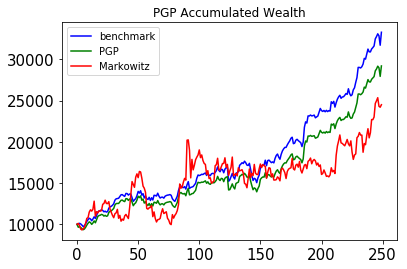

Markowitz_wealth:  24504.9700915 annualized rate of return: 0.201508255325
PGP_wealth:  29211.0988376 annualized rate of return: 0.245527105321
Benchmark:  33297.299955854185 annualized rate of return: 0.279379647132
Sharpe Ratio of Benchmark:	0.23677978252094237
Sharpe Ratio of Markowitz:	0.09266359776091772
Sharpe Ratio of PGP:	0.2133653446856647



(0.2133653446856647,
 0.23677978252094237,
 0.09266359776091772,
 [10000,
  9644.177801901262,
  9704.219868459943,
  9617.196529316208,
  9480.44469234867,
  9346.466413383521,
  9420.83581251314,
  9636.848863396115,
  9905.747834822268,
  10128.686391386516,
  10300.198989462559,
  10206.174184386493,
  9991.272540371534,
  10157.990242955306,
  10411.330845993074,
  10186.116315425179,
  10558.511037240884,
  10949.226072428904,
  11067.449340156712,
  11101.844863638202,
  11200.745359508655,
  11150.650699918206,
  10996.307990193447,
  11087.923818349815,
  10969.506666281568,
  11028.444665052268,
  11440.368290283339,
  11579.214008281666,
  11623.26151698988,
  11764.785481677687,
  11923.581424969821,
  12357.87505980709,
  12514.201925238762,
  12532.990126572218,
  12526.04982647855,
  12708.168677964468,
  12910.749755149933,
  12940.30256929191,
  12816.159284850874,
  12755.174812106943,
  13112.83562468533,
  13093.998478549018,
  12898.521044481893,
  13061.7073816311

In [230]:
FINAL_RESULT4 = runPGP(True,Vall,Sall,K1all,K2all,start=5,number_rebalances=249,x=initial,
                     lambda1 = 2.,lambda2 = 2.,lambda3 = 2.,lambda4 = 2.,lambda5=1.0)
print ""
FINAL_RESULT4

In [231]:
with open('final_result4','wb') as fr4:
    pickle.dump(FINAL_RESULT4,fr4)

In [232]:
with open('final_result4','rb') as fr4:
    FR4 = pickle.load(fr4)
FR4

(0.2133653446856647,
 0.23677978252094237,
 0.09266359776091772,
 [10000,
  9644.177801901262,
  9704.219868459943,
  9617.196529316208,
  9480.44469234867,
  9346.466413383521,
  9420.83581251314,
  9636.848863396115,
  9905.747834822268,
  10128.686391386516,
  10300.198989462559,
  10206.174184386493,
  9991.272540371534,
  10157.990242955306,
  10411.330845993074,
  10186.116315425179,
  10558.511037240884,
  10949.226072428904,
  11067.449340156712,
  11101.844863638202,
  11200.745359508655,
  11150.650699918206,
  10996.307990193447,
  11087.923818349815,
  10969.506666281568,
  11028.444665052268,
  11440.368290283339,
  11579.214008281666,
  11623.26151698988,
  11764.785481677687,
  11923.581424969821,
  12357.87505980709,
  12514.201925238762,
  12532.990126572218,
  12526.04982647855,
  12708.168677964468,
  12910.749755149933,
  12940.30256929191,
  12816.159284850874,
  12755.174812106943,
  13112.83562468533,
  13093.998478549018,
  12898.521044481893,
  13061.7073816311

In [158]:
FR2[5]

[10000,
 matrix([[10114.62987915]]),
 matrix([[9856.89306424]]),
 matrix([[9424.22816534]]),
 matrix([[9319.3268059]]),
 matrix([[9461.97092638]]),
 matrix([[9636.63237022]]),
 matrix([[10109.94946354]]),
 matrix([[10719.41480078]]),
 matrix([[10812.32530492]]),
 matrix([[11487.56810131]]),
 matrix([[11757.66521685]]),
 matrix([[11601.37739212]]),
 matrix([[11823.05897745]]),
 matrix([[12806.40440495]]),
 matrix([[10981.78762623]]),
 matrix([[11540.76997788]]),
 matrix([[11381.64021916]]),
 matrix([[11630.6239114]]),
 matrix([[11600.41384183]]),
 matrix([[11659.9253886]]),
 matrix([[12424.51013663]]),
 matrix([[12526.79891086]]),
 matrix([[12925.39333458]]),
 matrix([[12526.83652919]]),
 matrix([[12511.8191394]]),
 matrix([[12746.5246793]]),
 matrix([[11818.07745996]]),
 matrix([[11434.4975179]]),
 matrix([[11079.60395867]]),
 matrix([[10801.322759]]),
 matrix([[11282.7378456]]),
 matrix([[11395.39326044]]),
 matrix([[11813.04323914]]),
 matrix([[10731.95950916]]),
 matrix([[11083.1128

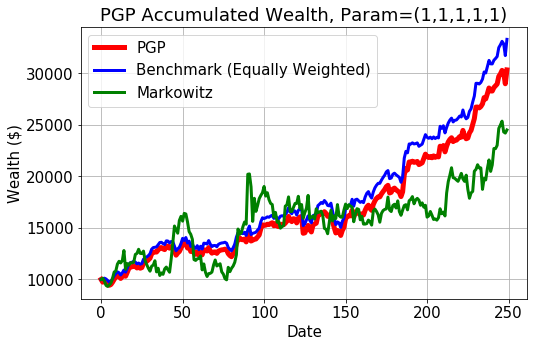

In [224]:
plt.figure(figsize=(8,5))
plt.title("PGP Accumulated Wealth, Param=(1,1,1,1,1)", fontsize=18)
plt.plot(range(len(FR2[3])),FR2[3],'r',label="PGP",linewidth=5)
plt.plot(range(len(FR2[4])),FR2[4],'b',label="Benchmark (Equally Weighted)",linewidth=3)
plt.plot(range(len(FR2[5])),FR2[5],'g',label="Markowitz",linewidth=3)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Wealth ($)",fontsize=15)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

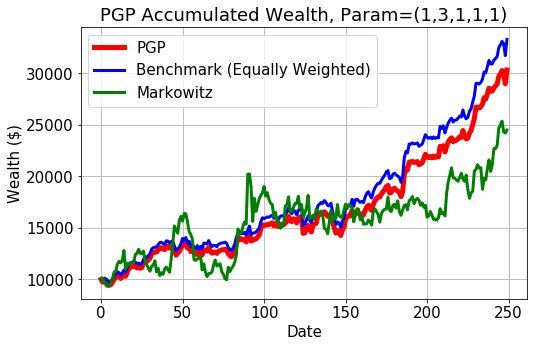

In [229]:
plt.figure(figsize=(8,5))
plt.title("PGP Accumulated Wealth, Param=(1,3,1,1,1)", fontsize=18)
plt.plot(range(len(FR3[3])),FR3[3],'r',label="PGP",linewidth=5)
plt.plot(range(len(FR3[4])),FR3[4],'b',label="Benchmark (Equally Weighted)",linewidth=3)
plt.plot(range(len(FR3[5])),FR3[5],'g',label="Markowitz",linewidth=3)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Wealth ($)",fontsize=15)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

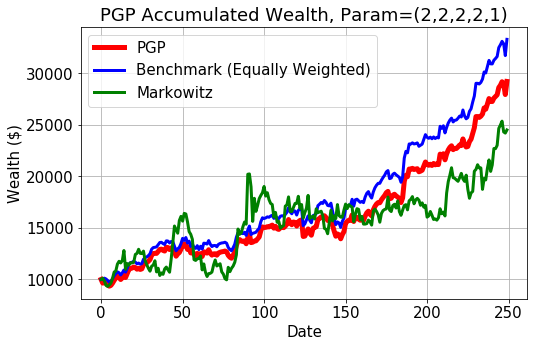

In [233]:
plt.figure(figsize=(8,5))
plt.title("PGP Accumulated Wealth, Param=(2,2,2,2,1)", fontsize=18)
plt.plot(range(len(FR4[3])),FR4[3],'r',label="PGP",linewidth=5)
plt.plot(range(len(FR4[4])),FR4[4],'b',label="Benchmark (Equally Weighted)",linewidth=3)
plt.plot(range(len(FR4[5])),FR4[5],'g',label="Markowitz",linewidth=3)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Wealth ($)",fontsize=15)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

In [206]:
id[40]

Timestamp('2013-05-01 00:00:00')